In [0]:
# Verify GPU
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [34]:
# Connect to images folder and set constants
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Data processing
import pandas as pd
import cv2


def dataset():
    images = []
    labels = []
    df = pd.read_csv(LABELS)
    for idx, row in df.iterrows():
      print("[process] ", idx)
      filepath = IMAGES_DIR + row['filename']
      label = row['score']
      image = cv2.imread(filepath)
      try:
        image = cv2.resize(image, (227, 227))
      except Exception as e:
        # In case image's size is smaller than 227 * 227
        pass
      images.append(image)
      labels.append(label)
    return images, labels


### *Training here*

In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.layers import (Dense, Dropout, Flatten, Activation,
                          Conv2D, MaxPooling2D, BatchNormalization)
from keras.layers.core import Activation
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import pickle
import os
import datetime

DIR = "/content/drive/My Drive/Facial_beauty/"
IMAGES_DIR = DIR + "Images/"
LABELS = 'https://raw.githubusercontent.com/ptran1203/facial_beauty/master/dataset/all_labels.csv'
BATCH_SIZE = 64
EPOCH = 100
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FIG_SIZE = (10,7)


def pickle_save(object, path):
    with open(path, "wb") as f:
        return pickle.dump(object, f)


def pickle_load(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def path(filename):
    return os.path.join(DIR, filename)

# Define path
model_path = path('model.json')
model_weight_path = path('model_weight.h5')
history_path = path('history.pkl')

# Load numpy images from drive
labels_np = pickle_load(os.path.join(DIR, "labels_np.pkl"))
imgs_np = pickle_load(os.path.join(DIR, "images_np.pkl"))

# split train/val
(trainX, valX, trainY, valY) = train_test_split(imgs_np,
	labels_np, test_size=VAL_SIZE, random_state=42)
# split train/test
(trainX, testX, trainY, testY) = train_test_split(trainX,
	trainY, test_size=TEST_SIZE, random_state=42)


# Create data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  rotation_range=45,
                                  brightness_range=[0.2,1.0],
                                  zoom_range=[0.5,1.0],
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)
test_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  rotation_range=45,
                                  brightness_range=[0.2,1.0],
                                  zoom_range=[0.5,1.0],)

def init_model():
    # initialize alexNet model
    model = Sequential()
    # Convolutional layers
    model.add(Conv2D(kernel_size=(11, 11),
                    activation='relu',
                    strides=(4, 4),
                    filters=96,
                    padding='valid',
                    input_shape=(227,227,3)))
    model.add(MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2),
                        padding='valid'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    padding='same',
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2),
                        padding='valid'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=384,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    activation='relu'))
    model.add(Conv2D(filters=384,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    activation='relu'))
    model.add(Conv2D(filters=256,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2),
                        padding='valid'))
    model.add(Flatten())
    # fully connected
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    # model.add(Dropout(0.5))
    # output
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_absolute_error',
                  optimizer=Adam(lr=1e-4),
                  metrics=['mse'])
    
    return model
  
def save(model, history):
    print('Saving the model ...')
    # save model structure
    with open(model_path, "w") as f:
        f.write(model.to_json())
    # save the weights and history
    model.save_weights(model_weight_path)
    pickle_save(history, history_path)
    print('done!')

def load_model():
    """
    Get model from Drive
    """
    json_file = open(model_path, 'r')
    model = json_file.read()
    json_file.close()
    model = model_from_json(model)
    # load weights into new model
    model.load_weights(model_weight_path)
    return model

def plot_history(H, save=True):
    plt.figure(figsize=FIG_SIZE)
    plt.plot(H.history['loss'])
    plt.plot(H.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(DIR + 'hist.png')
    plt.show()
    



In [0]:
model = init_model()
print(model.summary())
BATCH_SIZE = 16
EPOCH = 100
print('Train ', len(trainX), ' samples', 'Test ', len(testX), ' samples')
H = model.fit_generator(
            train_datagen.flow(trainX, trainY, batch_size=BATCH_SIZE),
            steps_per_epoch=len(trainX) // BATCH_SIZE,
            epochs=EPOCH,
            validation_data=test_datagen.flow(valX, valY)
            )

model.evaluate(testX, testY)
plot_history(H)
save(model, H)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 384)      

### Test *model*

In [0]:

from google.colab.patches import cv2_imshow
import pandas as pd
import cv2
import numpy as np
import urllib.request
from PIL import Image

model = load_model()
model.compile(loss='mean_absolute_error',
                optimizer=Adam(lr=1e-4),
                metrics=['mse'])


r = model.evaluate(testX / 255.0, testY)
print(model.metrics_names)
print(r)
# pre = model.predict(testX[:1] / 255.0)
# print(pre, testY[:1])
# H = pickle_load(history_path)
# plot_history(H)

def isvalid(img):
    return img.shape[0] > 0 and img.shape[1] > 0

def val(img):
    return img.shape[0] * img.shape[1]

def getface(img):
    allfaces = []
    face_cascade = cv2.CascadeClassifier( DIR + '/haarcascade_frontalface_default.xml')
    try:
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      faces = face_cascade.detectMultiScale(gray, 1.1, 4)
      height, width = img.shape[:2]
      for (x, y, w, h) in faces:
          face = img[y :min(y + h, height),
                    x -50 :min(x + w, width)]
          # only get the first one
          if (isvalid(face)):
            allfaces.append(face)
    except:
      return img
    
    if (len(allfaces)):
      return sorted(allfaces, key=lambda x: -val(x))[0]
    return img

def predict(img_path):
    img = None
    if img_path.startswith('http') or \
       img_path.startswith('data:image/jpeg'):
        req = urllib.request.urlopen(img_path)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        img = cv2.imdecode(arr, -1)
    else:
        img = cv2.imread(img_path)
    
    # Crop the face
    img = getface(img)
    try:
      img = cv2.resize(img, (227, 227))
    except:
      pass
    cv2_imshow(img)  
    img = np.expand_dims(img / 255.0, axis=0)
    pre = model.predict(img)[0]
    print(str(round(pre[0], 2)))
    return pre

imgpaths = [DIR + 'test_imgs/' + path for path in os.listdir(DIR + 'test_imgs')]


for path in imgpaths:
  predict(path)


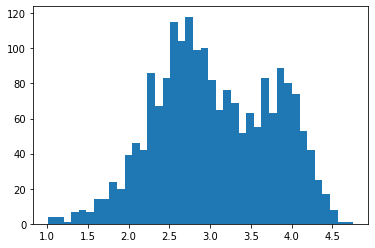

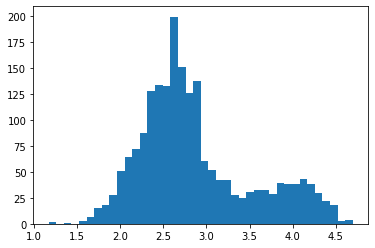

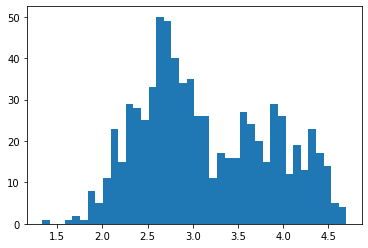

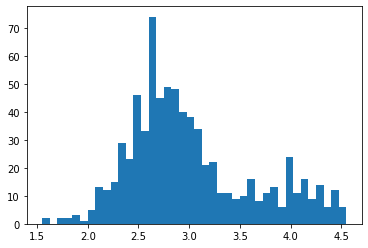

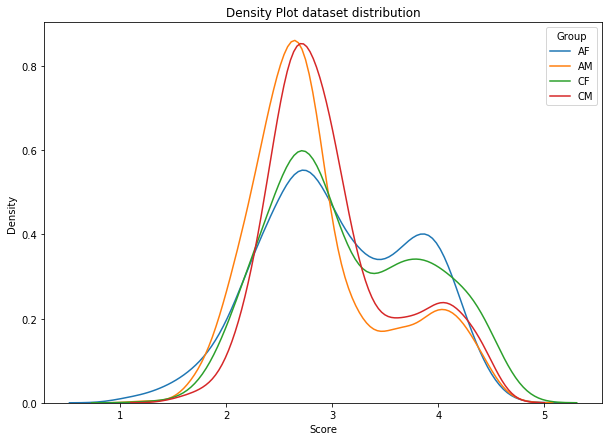

In [33]:
def plot_hist_per_label(group):
    for gr, vals in group.items():
        plt.hist(vals, bins=40, label = gr)
        # sns.distplot(vals, kde=True, hist=False, label=gr)
        # plt.legend(loc='upper right')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.savefig(DIR + 'dataset_' + gr + '.png') 
        plt.show()


def plot_one_density(group):
    plt.figure(figsize=FIG_SIZE)
    for gr, vals in group.items():
        sns.distplot(vals, kde=True, hist=False, label=gr)
    plt.legend( title = 'Group')
    plt.title('Density Plot dataset distribution')
    plt.xlabel('Score')
    plt.ylabel('Density')

def dataset_distribute():
    df = pd.read_csv(LABELS)
    group_ = {
        'AF': [],
        'AM': [],
        'CF': [],
        'CM': [],
    }

    def fgroup(filename):
        for g in group_.keys():
          if g in filename:
            return g
        return False

    labels = df['score']
    files = df['filename']
    for i in range(len(labels)):
        filename = files[i]
        label = labels[i]
        gname = fgroup(filename)
        group_[gname].append(label)
    
    plot_hist_per_label(group_)
    plot_one_density(group_)

       

dataset_distribute()
# H = pickle_load(history_path)
# plot_history(H)
